In [0]:
# Let MNIST(alpha) be MNIST with Gaussian noise of SD alpha added to the pixels.
# Group any five classes to be the positive class and the rest to be the negative class.
# Add a 3x3 patch on the left/right based on whether the image is positive or negative. Let's call these modified datasets as MNIST_bin_patch(alpha).
# Also define the patchless versions of these datasets as MNIST_bin(alpha).
# Train a linear model on these datasets for an appropriate range of alpha values. Only select architectures that have good training and testing performance on the 
# patchless version of the dataset (this is to rule out really bad architectures and really bad datasets).

# Test all these models (trained on the patched version of the data) on the test set of MNIST_bin_patch(alpha), MNIST_bin(alpha), i.e. the model is tested on the data 
# with which it is trained, and also the patchless version. Choose the model/dataset for which the difference between the two is greatest. 
# (The accuracy on the patched data is much higher than the accuracy on the data without patches). 
# Now the goal is to train a model with the same architecture of the chosen model that does well on both the patched data and the patchless data. 



# Model learns beter when trained on the dat awith partches than eithout patches!
# In case of training on no patches, 
# for 1 classifier, loss starts with 
# for 2 classifiers with lambda = 0, loss starts from 612...Training and test loss (on patchless data) is around 89%
# for 2 classifiers with lambda = 1, loss starts from 636...Training and test loss (on patchless data) is around 89%

# In case of training with patches (28*4)
# for 2 classifier, with lambda = 1, loss starts from 10.7...training accuracy is 100%, test acc on path data is 100 and that on patchless is around 80%

# In case of training with patches (3*3)
#######################
# For 2 classifiers with 0 lambda, model clearly learns patches as apparent from the weight vector images

#######################
# for 2 classifier, with lambda = 1, loss starts from 10.7...training accuracy is 100%, test acc on path data is 100 and that on patchless is around 80%

# The test accuracy on patchless data is highest when trained on patch less data (89% for both test and train).
# As the size of patch grows, train accuracy grows to 100%, while test accuracy on patchless data reduces. Test accuracy on data with patches is 100%.
# So as the patch size grows, the model begins to primrily learn the left-right patch rather than odd-even
# Even the newly added dot product loss doesn't seem to make the 2 classifiers learn different tasks

# Even the fancy dot product loss seems to learn both the tasks for both models
# It tries to make the vectors orthogonal in the parts except the patches


# data type matters because conversion to float and again to int gives the same results as no conversion...

In [0]:
# For improving the model expeiments, alpha = 150. Test accuracy on patchless data falls from 82% to 63% for a 3*3 patch

In [0]:
# Training 16 models
# The train and test acc. is 98%. The visualization of weight vectors reveals that the left and right patches are not as prominent as they used to be for 2 models

# Training 10 models
# The train and test acc. is 98%. The visualization of weight vectors reveals that the left and right patches are not as prominent as they used to be for 2 models
# With fancy inner product, train and test on patches has 99% accuracy; max patchless acc. among all models is 62%

### Training multiple models (on patched version) by forcing orthogonality has lesser accuracy (on patchless version) as compared to training a single model 
# sigma = 0.01, 1 (not good) with lambda = 50 and 20 epochs around 60% acc
# sigma = 1, lambda = 50 and 25 epochs 

In [0]:
alpha = 100 # taking 150 because visually makes more sense for human eye

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])

trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

trainset_forpatch = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform)

testset_forpatch = torchvision.datasets.MNIST(root = './data', train = False, download = True, transform = transform)

0it [00:00, ?it/s]

9920512it [00:01, 7431191.80it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135685.09it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2199642.12it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 51538.73it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
# label [1, 2, 3, 4, 5] as 0, others as one
trainset.targets[np.where(trainset.targets %2 != 0)[0].tolist()] = 1
trainset.targets[np.where(trainset.targets %2 == 0)[0].tolist()] = 0

testset.targets[np.where(testset.targets %2 != 0)[0].tolist()] = 1
testset.targets[np.where(testset.targets %2 == 0)[0].tolist()] = 0

trainset_forpatch.targets[np.where(trainset_forpatch.targets %2 != 0)[0].tolist()] = 1
trainset_forpatch.targets[np.where(trainset_forpatch.targets %2 == 0)[0].tolist()] = 0

testset_forpatch.targets[np.where(testset_forpatch.targets %2 != 0)[0].tolist()] = 1
testset_forpatch.targets[np.where(testset_forpatch.targets %2 == 0)[0].tolist()] = 0

In [0]:
# Converting the data type to float in order to be able to add Gaussian noise
trainset.data = trainset.data.type(torch.float64)
testset.data = testset.data.type(torch.float64)
trainset_forpatch.data = trainset_forpatch.data.type(torch.float64)
testset_forpatch.data = testset_forpatch.data.type(torch.float64)

In [0]:
# Generating MNIST_bin(alpha)
def GaussianNoise_alpha(trainset1, testset1, alpha):
  for im in range(len(trainset1)):
#     trainset1.data[im] = torch.tensor(trainset1.data[im], dtype = torch.float64) + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    trainset1.data[im] = trainset1.data[im] + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    trainset1.data[im] = np.clip(trainset1.data[im], 0, 255)
  for jm in range(len(testset1)):
#     testset1.data[jm] = torch.tensor(testset1.data[jm], dtype = torch.float64) + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    testset1.data[jm] = testset1.data[jm] + torch.tensor(np.random.normal(scale = alpha, size = (28, 28)), dtype = torch.float64)
    testset1.data[jm] = np.clip(testset1.data[jm], 0, 255)
  return trainset1, testset1


# Generating MNIST_bin_patch(alpha)
def GaussianNoise_alpha_patch(trainset1, testset1): # Feed in the data with gaussian noise already added
# Left patch for   
  for im in range(len(trainset1)):
    if trainset1.targets[im] == 0:
      for p1 in range(3):
        for p2 in range(3):
          trainset1.data[im][p1, p2] = 255
    else:
      for p1 in range(3):
        for p2 in range(25, 28):
          trainset1.data[im][p1, p2] = 255

  for im in range(len(testset1)):
    if testset1.targets[im] == 0:
      for p1 in range(3):
        for p2 in range(3):
          testset1.data[im][p1, p2] = 255
    else:
      for p1 in range(3):
        for p2 in range(25, 28):
          testset1.data[im][p1, p2] = 255
          
  return trainset1, testset1 

In [0]:
# Creating the bin data
train_bin, test_bin = GaussianNoise_alpha(trainset, testset, alpha)

# # Creating the bin data with patches
train_inter, test_inter = GaussianNoise_alpha(trainset_forpatch, testset_forpatch, alpha)
train_bin_patch, test_bin_patch = GaussianNoise_alpha_patch(train_inter, test_inter)

In [0]:
# Converting the data type back to unit8...

train_bin.data = train_bin.data.type(torch.uint8)
test_bin.data = test_bin.data.type(torch.uint8)
train_bin_patch.data = train_bin_patch.data.type(torch.uint8)
test_bin_patch.data = test_bin_patch.data.type(torch.uint8)

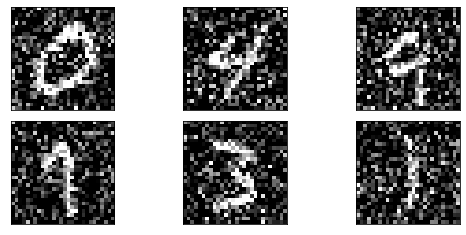

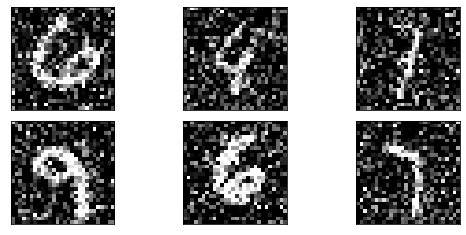

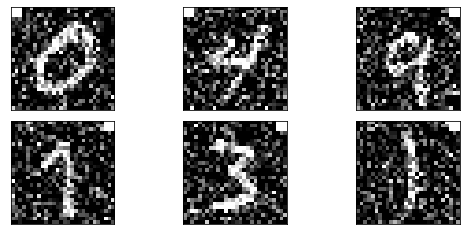

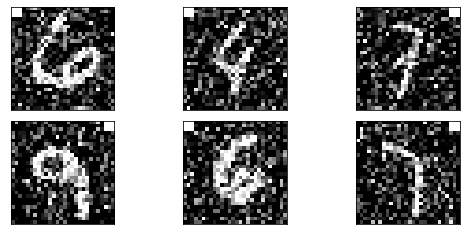

In [8]:
# Plot random train and test images
# Training images
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 115, 460, 212, 130, 10020], axes.flat):
    ax.imshow(train_bin.data[i], cmap='gray')
    
#Test images without patch 
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([201, 115, 1500, 212, 130, 122], axes.flat):
    ax.imshow(test_bin.data[i], cmap='gray')  
    
# Training images
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([1, 115, 460, 212, 130, 10020], axes.flat):
    ax.imshow(train_bin_patch.data[i], cmap='gray')
    
# Test images without patch 
fig, axes = plt.subplots(2, 3, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in zip([201, 115, 1500, 212, 130, 122], axes.flat):
    ax.imshow(test_bin_patch.data[i], cmap='gray')      

In [0]:
# Assign data to data loader

trainloader = torch.utils.data.DataLoader(train_bin, batch_size = 64, shuffle = True, num_workers = 2)

testloader = torch.utils.data.DataLoader(test_bin, batch_size = 64, shuffle = False, num_workers = 2)

trainloader_patch = torch.utils.data.DataLoader(train_bin_patch, batch_size = 64, shuffle = True, num_workers = 2)

testloader_patch = torch.utils.data.DataLoader(test_bin_patch, batch_size = 64, shuffle = False, num_workers = 2)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class linear_model(nn.Module):
  def __init__(self):
    super(linear_model, self).__init__()
    self.fc1 = nn.Linear(28*28, 1)
    self.fc2 = nn.Linear(28*28, 1)
    self.fc3 = nn.Linear(28*28, 1)
    self.fc4 = nn.Linear(28*28, 1)
    self.fc5 = nn.Linear(28*28, 1)
    self.fc6 = nn.Linear(28*28, 1)
    self.fc7 = nn.Linear(28*28, 1)
    self.fc8 = nn.Linear(28*28, 1)
    self.fc9 = nn.Linear(28*28, 1)
    self.fc10 = nn.Linear(28*28, 1)
    self.fc11 = nn.Linear(28*28, 1)
    self.fc12 = nn.Linear(28*28, 1)
    self.fc13 = nn.Linear(28*28, 1)
    self.fc14 = nn.Linear(28*28, 1)
    self.fc15 = nn.Linear(28*28, 1)
    self.fc16 = nn.Linear(28*28, 1)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x1 = torch.sigmoid(self.fc1(x))  
    x2 = torch.sigmoid(self.fc2(x))  
    x3 = torch.sigmoid(self.fc3(x))  
    x4 = torch.sigmoid(self.fc4(x))  
    x5 = torch.sigmoid(self.fc5(x))  
    x6 = torch.sigmoid(self.fc6(x))  
    x7 = torch.sigmoid(self.fc7(x))  
    x8 = torch.sigmoid(self.fc8(x))  
    x9 = torch.sigmoid(self.fc9(x))  
    x10 = torch.sigmoid(self.fc10(x))  
    x11 = torch.sigmoid(self.fc11(x))  
    x12 = torch.sigmoid(self.fc12(x))  
    x13 = torch.sigmoid(self.fc13(x))  
    x14 = torch.sigmoid(self.fc14(x))  
    x15 = torch.sigmoid(self.fc15(x))  
    x16 = torch.sigmoid(self.fc16(x))  
    return x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16
  
model = linear_model()  

In [0]:
#Script for generating fancy inner product matrix:

sigma = 10 ############HIGHER VALUES OF SIGMA SEEM TO PERFORM BETTER#############
M = torch.zeros([28*28, 28*28])

M_tensor = M.view(28,28,28,28)

for i_1 in range(28):
    for i_2 in range(28):
        for j_1 in range(28):
            for j_2 in range(28):
                M_tensor[i_1,i_2,j_1,j_2] = np.exp( -((i_1 - j_1)**2 + (i_2 - j_2)**2)/(2 * (sigma)**2) )

M = M_tensor.view([28*28,28*28])

In [0]:
# Define loss function and optimizer
import torch.optim as optim

loss_function = nn.BCELoss(reduction = 'mean') # sums all outputs and divides by total data points

optimizer = optim.Adam(model.parameters(), lr = 0.001)

class custom_loss(torch.nn.Module):

  def __init__(self):
    super(custom_loss,self).__init__()

  def forward(self, mat1, mat2, M):
  # Absolute dot product of weights
#     l = (torch.mm(mat1, mat2.t()))**2

  # Fancy dot product if weights
    l = (torch.mm(mat1, torch.mm(M, mat2.t())))**2
    return l

sl = custom_loss()    

In [0]:
models_forloss = [model.fc1.weight, model.fc2.weight, model.fc3.weight, model.fc4.weight, model.fc5.weight, model.fc6.weight, model.fc7.weight, model.fc8.weight, 
      model.fc9.weight, model.fc10.weight, model.fc11.weight, model.fc12.weight, model.fc13.weight, model.fc14.weight, model.fc15.weight, model.fc16.weight]

In [39]:
n_epochs = 30
lmbda = 50

for epochs in range(n_epochs):
 
  running_loss = 0
  
  for batch in trainloader_patch:
    data, targets = batch
    
    optimizer.zero_grad()
    
    output = model(data)
    
    loss = loss_function(output[0], targets.view(-1, 1).float())
    
    for mm in range(1, len(models_forloss)):
      
      loss += loss_function(output[mm], targets.view(-1, 1).float())
    
    for fr in range((len(models_forloss) - 1)):
      
      for sn in range(fr + 1, len(models_forloss)):  
        
        loss += lmbda * sl.forward(models_forloss[fr], models_forloss[sn], M)[0][0]

    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
  print(running_loss)    

6741.961539983749
2267.0349375009537
1279.485065817833
919.9324316382408
822.7418057024479
621.4543329179287
584.7376155555248
9581.19468575716
402.5467450618744
386.6839978992939
364.98322466015816
336.5483537018299
333.4618203788996
335.71530467271805
331.16739620268345
333.00345063209534
404.31976936757565
321.9544662684202
28270.683450326324
210.98342756927013
208.88784629106522
206.27105958759785
202.31179684400558
196.35657626390457
187.7159429639578
177.61452797055244
198.47857151925564
205.9293877929449
40379.40912805498
626.3887474238873


In [40]:
# # Test performance on the entire test set
# correct = 0
# total = 0
# with torch.no_grad():
#   for data in testloader:
#     images, labels = data
#     outputs = model(images)
# #     _, predicted = torch.max(outputs, 1)
#     predicted = outputs > 0.5
# #     predicted = predicted.view(predicted.size(0))
#     total += labels.size(0)
#     matches = 0
#     for i in range(len(predicted)):
#       if predicted[i].item() == labels[i].item():
#         matches += 1
#     correct += matches#(predicted == labels).sum().item()
#   print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = model(images)
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs[15] > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 63 %


In [0]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in trainloader_patch:
    images, labels = data
    outputs = model(images)
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 100 %


In [0]:
# Test performance on the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in testloader_patch:
    images, labels = data
    outputs = model(images)
#     _, predicted = torch.max(outputs, 1)
    predicted = outputs > 0.5
#     predicted = predicted.view(predicted.size(0))
    total += labels.size(0)
    matches = 0
    for i in range(len(predicted)):
      if predicted[i].item() == labels[i].item():
        matches += 1
    correct += matches#(predicted == labels).sum().item()
  print('Accuracy of the network on the entire data set is : %d %%' %(100 * correct/ total))

Accuracy of the network on the entire data set is : 100 %


Total energy of weight 1 : 2.5858841508254717
Total energy of patches of weight 1 : 1.745869938618898
Total energy of weight 2 : 2.3989223665793458
Total energy of patches of weight 2 : 1.9005424871099086


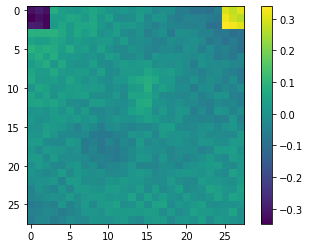

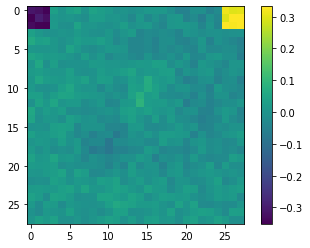

<Figure size 432x288 with 0 Axes>

In [34]:
W1 = model.fc14.weight.detach().numpy()
W1_reshape = np.reshape(W1, (28, 28))
plt.imshow(W1_reshape)
plt.colorbar()
plt.figure()

energy_patch1 = 0
energy_total1 = 0

for r in range(28):
  for c in range(28):
      energy_total1 += (W1_reshape[r, c])** 2
      if r < 3 and c in [0, 1, 2, 25, 26, 27]:
        energy_patch1 += (W1_reshape[r, c])**2

print('Total energy of weight 1 :', energy_total1)
print('Total energy of patches of weight 1 :', energy_patch1)

W2 = model.fc7.weight.detach().numpy()
W2_reshape = np.reshape(W2, (28, 28))
plt.imshow(W2_reshape)
plt.colorbar()
plt.figure()

energy_patch2 = 0
energy_total2 = 0

for r in range(28):
  for c in range(28):
      energy_total2 += (W2_reshape[r, c])** 2
      if r < 3 and c in [0, 1, 2, 25, 26, 27]:
        energy_patch2 += (W2_reshape[r, c])**2

print('Total energy of weight 2 :', energy_total2)
print('Total energy of patches of weight 2 :', energy_patch2)

In [0]:
# # Tabluate the train and test accuracy on the un-patched data for different values of SD (alpha)
# train_accuracy = [0.89, 0.86, 0.82, 0.81, 0.69]
# test_accuracy = [0.89, 0.85,0.82, 0.80, 0.67]
# alphas_ = [1, 100, 150, 200, 500]

In [0]:
# # Choose value of alpha as 2 for further analysis

# ### Training on patches (4*4 patch)
# train_acc_patch = [1, 1 ,1]
# test_acc_patch = [1,1 ,1]
# test_acc_patchless = [0.77, 0.68, 0.64]

# ### Training on patches (3*3 patch)
# train_acc_patch = [1, 1, 1]
# test_acc_patch = [1, 1, 1]
# test_acc_patchless = [0.75, 0.66, 0.62]

In [0]:
# for sigma = 0.01, lmbda = 500, accuracy is 67% in 10 epochs

In [0]:
###############GOOD COMINATIONS#################
# sigma = 10, lambda - 50, epochs = 15
# sigma = 50, lambda - 50, epochs = 20 test acc patchless ~ 0.75, 0.76 is highest
####Accuracy seems improve when training more than 2 models?
# For 2 models and sigma = 100, lambda = 50 and 25 epochs - 0.79 acc
# For 2 models and sigma = 100, lambda = 100 and 25 epochs - .74  acc
# For 2 models and sigma = 100, lambda = 10, 25 and 25 epochs - .71  acc

#####IMPORTANT OBSERVATIONS#############
# Higher values of sigma (say 100) perform better than lower ones (say 0.1)

########Tasks#############################
# Establish variation of performance with sigma,  lambda and number of classifiers
# Performance decreases with increase in sigma?


In [0]:
######RESULS########

#16 classifiers, Sigma - 50, 30 epochs, lambda 50 -- 0.79 is highest acc (many classifiers have 0.79 accuracy)
#16 classifiers, Sigma - 50, 30 epochs, lambda 100 -- 0.77 is highest acc many classifiers have 0.76 accuracy)
#16 classifiers, Sigma - 500, 30 epochs, lambda 50 -- 0.76  is highest acc (many classifiers have 0.75-0.76 accuracy)
#16 classifiers, Sigma - 100, 30 epochs, lambda 50 --  0.76 is highest acc (many classifiers 0.76 have accuracy)
#16 classifiers, Sigma - 50, 30 epochs, lambda 150 -- 0.77 is highest acc (many classifiers have 0.75-0.76 accuracy)
#16 classifiers, Sigma - 50, 30 epochs, lambda 100 -- 0.76 is highest acc (many classifiers have 0.75-0.76 accuracy)
#16 classifiers, Sigma - 25, 30 epochs, lambda 50 -- 0.77 is highest acc (many classifiers have 0.75 accuracy)